In [4]:
import numpy as np
from sympy import symbols, Matrix, diff, sin, cos, pprint
from sympy.utilities.lambdify import lambdify
from scipy.integrate import solve_ivp, odeint
from scipy.linalg import solve_continuous_are, inv
from matplotlib import pyplot as plt

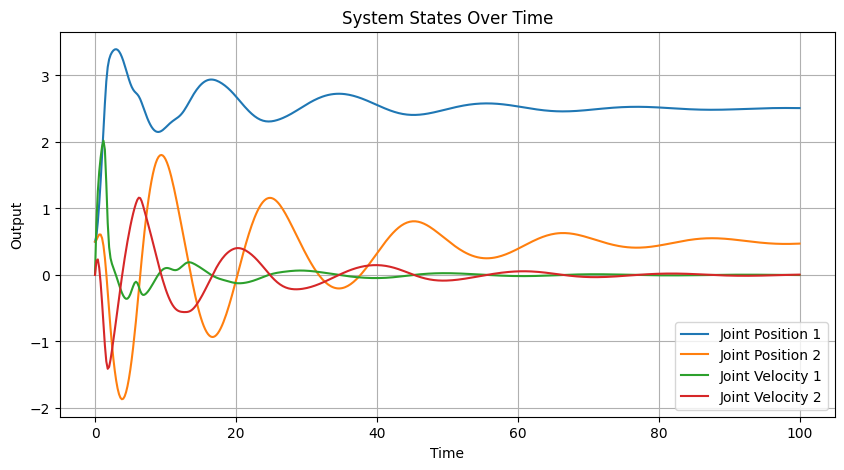

In [29]:
m1, m2 = 1, 1 #kg
l1, l2 = 1, 1 #m
g = 9.81 #m/s^2

q1, q2, q1dot, q2dot = symbols('q1 q2 q1dot q2dot')
q = Matrix([q1, q2, q1dot, q2dot])

M11 = 1/3*m1*l1**2 + 1/3*m2*l2**2 + m2*l1**2 + m2*l1*l2*cos(q2)
M12 = M21 = 1/3*m2*l2**2 + 1/2*m2*l1*l2*cos(q2)
M22 = 1/3*m2*l2**2
M = Matrix([[M11, M12], [M21, M22]])
M_func = lambdify((q1, q2, q1dot, q2dot), M, 'numpy')

C11 = -1/2*m2*l1*l2*q2dot*sin(q2)
C12 = -1/2*m2*l1*l2*sin(q2)*(q1dot + q2dot)
C21 = -1/2*m2*l1*l2*q1dot*sin(q2)
C22 = 0
C = Matrix([[C11, C12], [C21, C22]])*Matrix([[q1dot], [q2dot]])
C_func = lambdify((q1, q2, q1dot, q2dot), C, 'numpy')

G1 = (1/2*m1*l1 + m2*l1)*g*cos(q1) + 1/2*m2*l2*g*cos(q1 + q2)
G2 = 1/2*m2*l2*g*cos(q1 + q2)
G = Matrix([[G1], [G2]])
G_func = lambdify((q1, q2, q1dot, q2dot), G, 'numpy')

matrix_cal = Matrix([[M11, M12], [M21, M22]]).inv() * Matrix([[C11*q1dot, C12*q2dot], [C21*q1dot, C22*q2dot]])

f_row1 = q1dot
f_row2 = q2dot
f_row3 = matrix_cal[0] - G1
f_row4 = matrix_cal[1] - G2
f = Matrix([f_row1, f_row2, f_row3, f_row4])
f_func = lambdify((q1, q2, q1dot, q2dot), f, 'numpy')

q1_desired = 1.5
q2_desired = 0.5

def control_pd(q):
    q1, q2, q1dot, q2dot = q
    # Position Error
    e_q = 1.0*np.array([[q1_desired - q1], [q2_desired - q2]])
    # Velocity Error
    e_qdot = 1.0*np.array([[0 - q1dot], [0 - q2dot]])
    return e_q + e_qdot

def control_linearization(v, q):
    """This control law simply does feedback linearization without LQR control. This means you can put any value of v in, and the system will have that slope."""
    q1, q2, q1dot, q2dot = q
    M = M_func(q1, q2, q1dot, q2dot)
    C = C_func(q1, q2, q1dot, q2dot)
    G = G_func(q1, q2, q1dot, q2dot)
    tau = M@v + C + G
    return np.vstack((np.zeros((2,1)), tau))

def system_dynamics_full(t, q):
    q1, q2, q1dot, q2dot = q
    v = control_pd(q)
    q_dot = f_func(q1, q2, q1dot, q2dot) + control_linearization(v, q)
    return q_dot.flatten()

# Initial conditions
q0 = [0.5, 0.5, 0.0, 0.0]

# Time span
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solving the differential equation
solution = solve_ivp(system_dynamics_full, t_span, q0, t_eval=t_eval)
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='Joint Position 1')
plt.plot(solution.t, solution.y[1], label='Joint Position 2')
plt.plot(solution.t, solution.y[2], label='Joint Velocity 1')
plt.plot(solution.t, solution.y[3], label='Joint Velocity 2')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System States Over Time')
plt.legend()
plt.grid(True)
plt.show()